# IMAGE WARPING and MOSAICING

In [1]:
import cv2

import numpy as np
import skimage as sk
import skimage.io as skio
from matplotlib import pyplot as plt

from skimage.draw import polygon
from Utils.ImagePointSet import ImagePointSet
from scipy.interpolate import griddata
from Utils.raw_image_operations import save_image

(327, 828, 3)


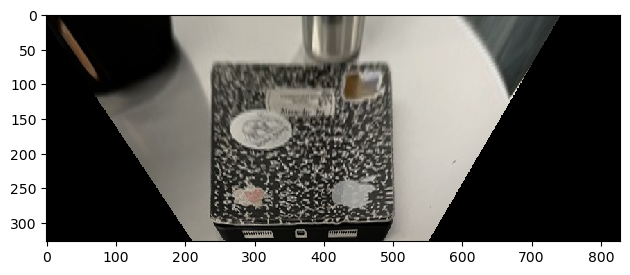

In [53]:
DEFAULT_CANVS_PADDING = 20

def compute_homography_matrix(src_points, dest_points):
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("At least 4 points are required.")
    if src_points.shape != dest_points.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    x, y = src_points[:, 0], src_points[:, 1]
    x_prime, y_prime = dest_points[:, 0], dest_points[:, 1]
    
    zeros = np.zeros(x.shape)
    ones = np.ones(x.shape)
    
    A1 = np.column_stack((-x, -y, -ones, zeros, zeros, zeros, x*x_prime, y*x_prime, x_prime))
    A2 = np.column_stack((zeros, zeros, zeros, -x, -y, -ones, x*y_prime, y*y_prime, y_prime))
    
    A = np.row_stack((A1, A2))

    _, _, vh = np.linalg.svd(A)
    homography_matrix = vh[-1].reshape(3, 3)
    
    return homography_matrix

# Used to verify method
def wrap_image_with_cv2(image, projection_matrix):
    h, w, _ = image.shape
    
    wrapped_image = cv2.warpPerspective(image, projection_matrix, (w + 100, h + 100))
    
    return wrapped_image

def apply_homography(x, y, homography_matrix):
    homogenous_coords = np.vstack((x, y, np.ones(x.size)))
    
    warped_homogenous_coords = np.dot(homography_matrix, homogenous_coords)
    warped_coords = (warped_homogenous_coords / warped_homogenous_coords[2])
    return warped_coords[0], warped_coords[1]

def get_warp_corners(image, homography_matrix):
    h, w, _ = image.shape
    image_corners = np.array([
        [0 ,0],
        [0, h - 1],
        [w - 1, h - 1],
        [w - 1, 0]
    ])
    
    return np.array(apply_homography(image_corners[:, 0], image_corners[:, 1], np.linalg.inv(homography_matrix)))

def get_all_points(image):
    h, w, _ = image.shape
    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    x, y = np.meshgrid(x, y)
    return x.flatten().astype(int), y.flatten().astype(int)

def get_all_points_using_polygon(image):
    h, w, _ = image.shape
    rr, cc = polygon([0, 0, h-1, h-1], [0, w-1, w-1, 0], shape=image.shape)
    return cc, rr

def get_warp_canvas_basics(image, homography_matrix):
    warped_corner_x, warped_corner_y = get_warp_corners(image, homography_matrix)
    warped_x_min, warped_y_min = np.min(warped_corner_x), np.min(warped_corner_y)
    
    warped_w = np.max(warped_corner_x) - warped_x_min if warped_x_min < 0 else np.max(warped_corner_x)
    warped_h = np.max(warped_corner_y) - warped_y_min if warped_y_min < 0 else np.max(warped_corner_y)
    
    warped_canvas = np.zeros((int(warped_h) + 1, int(warped_w) + 1, 3))
    
    return warped_canvas, warped_x_min, warped_y_min

def warp_image(image, homography_matrix):
    warped_canvas, warped_x_min, warped_y_min = get_warp_canvas_basics(image, homography_matrix)
    h, w, _ = warped_canvas.shape
    warped_x, warped_y = get_all_points(warped_canvas)
    
    canvas_x = warped_x.astype(int)
    canvas_y = warped_y.astype(int)
    
    warped_x = warped_x + warped_x_min if warped_x_min < 0 else warped_x
    warped_y = warped_y + warped_y_min if warped_y_min < 0 else warped_y
    
    warped_x, warped_y = apply_homography(warped_x, warped_y, np.linalg.inv(homography_matrix))
    # warped_x = warped_x + warped_x_min
    # warped_y = warped_y + warped_y_min   
    
    warped_canvas[canvas_y, canvas_x, :] = griddata(
        get_all_points(image),
        image.reshape(-1, 3),
        (warped_x, warped_y),
        method='linear',
        fill_value=0
    )
    
    return warped_canvas.reshape(h, w, 3)

ipad_image_set = ImagePointSet("ipad_ipad.json")
ipad_image_set_matrix = compute_homography_matrix(ipad_image_set.points[0], ipad_image_set.points[1])
rectified_ipad_image = warp_image(ipad_image_set.images[0], ipad_image_set_matrix)
print(rectified_ipad_image.shape)
skio.imshow(rectified_ipad_image)
skio.show()

#(426, 927, 3)
#(358, 500, 3)

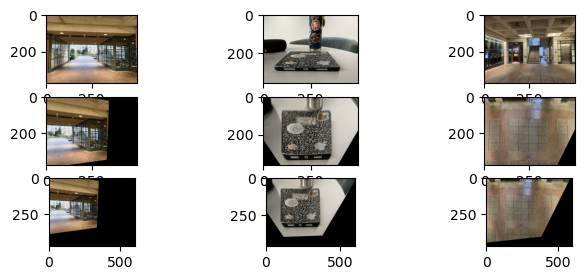

In [3]:
hallway0_hallway1 = ImagePointSet("hallway/hallway1_hallway2.json")
hallway0_hallway1_projection_matrix = compute_homography_matrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
warped_hallway0_hallway1_image = warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)

ipad_image_set = ImagePointSet("ipad_ipad.json")
ipad_image_set_matrix = compute_homography_matrix(ipad_image_set.points[0], ipad_image_set.points[1])
rectified_ipad_image = warp_image(ipad_image_set.images[0], ipad_image_set_matrix)
save_image(rectified_ipad_image, "rectified_ipad_image")

hallway1_rectify_image_set = ImagePointSet("hallway/hallway4_rectify.json")
hallway1_rectify_set_matrix = compute_homography_matrix(hallway1_rectify_image_set.points[0], hallway1_rectify_image_set.points[1])
rectified_hallway1_rectify_image = warp_image(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix)
save_image(rectified_hallway1_rectify_image, "rectified_hallway4_rectify_image")


_, axes = plt.subplots(3, 3, figsize=(8, 3))
axes[0, 0].imshow(hallway0_hallway1.images[0])
axes[0, 1].imshow(ipad_image_set.images[0])
axes[0, 2].imshow(hallway1_rectify_image_set.images[0])
axes[1, 0].imshow(warped_hallway0_hallway1_image)
axes[1, 1].imshow(rectified_ipad_image)
axes[1, 2].imshow(rectified_hallway1_rectify_image)
axes[2, 0].imshow(wrap_image_with_cv2(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix))
axes[2, 1].imshow(wrap_image_with_cv2(ipad_image_set.images[0], ipad_image_set_matrix))
axes[2, 2].imshow(wrap_image_with_cv2(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix))

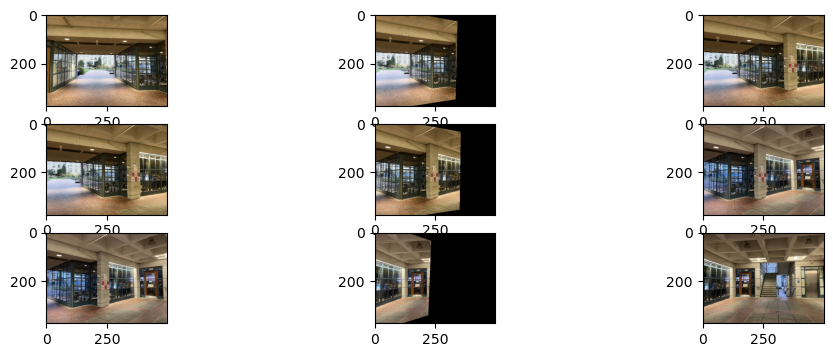

In [4]:
hallway_point_sets = [
    ImagePointSet("hallway/hallway1_hallway2.json"),
    ImagePointSet("hallway/hallway2_hallway3.json"),
    ImagePointSet("hallway/hallway3_hallway4.json")
]
for set in hallway_point_sets:
    set.align_all_points()

hallway_projection_matrix_list = [compute_homography_matrix(pt_set.points[0], pt_set.points[1]) for pt_set in hallway_point_sets]
warped_hallway_projections = [warp_image(pt_set.images[0], proj_matrix) for pt_set, proj_matrix in zip(hallway_point_sets, hallway_projection_matrix_list)]

mosaic_seq = []
for image_point_set, warped_image in zip(hallway_point_sets, warped_hallway_projections):
    seq_set = (image_point_set.images[0], warped_image, image_point_set.images[1])
    mosaic_seq.append(seq_set)

_, axes = plt.subplots(len(mosaic_seq), 3, figsize=(12, 4))
for i in range(len(mosaic_seq)):
    axes[i, 0].imshow(mosaic_seq[i][0])
    axes[i, 1].imshow(mosaic_seq[i][1])
    axes[i, 2].imshow(mosaic_seq[i][2])
        

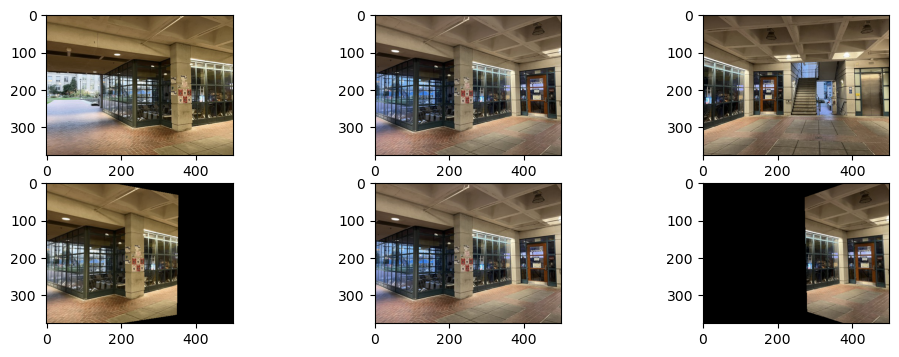

In [5]:
left_mosaic, center_mosaic, right_mosaic = hallway_point_sets[1].images[0], hallway_point_sets[1].images[1], hallway_point_sets[2].images[1]
left_points, right_points = hallway_point_sets[1].points[0], hallway_point_sets[2].points[1]
left_2_center_points = hallway_point_sets[1].points[1]
right_2_center_points = hallway_point_sets[2].points[0]

left_2_center_matrix, right_2_center_matrix = compute_homography_matrix(left_points, left_2_center_points), compute_homography_matrix(right_points, right_2_center_points)

warped_left_mosaic = warp_image(left_mosaic, left_2_center_matrix)
warped_right_mosaic = warp_image(right_mosaic, right_2_center_matrix)

_, axes = plt.subplots(2, 3, figsize=(12, 4))
axes[0, 0].imshow(left_mosaic)
axes[0, 1].imshow(center_mosaic)
axes[0, 2].imshow(right_mosaic)
axes[1, 0].imshow(warped_left_mosaic)
axes[1, 1].imshow(center_mosaic)
axes[1, 2].imshow(warped_right_mosaic)